Author: Akshay Chougule

Originally Created On: Nov 12, 2023

v2 created on: Nov 17, 2023

Credit: The pre-testing setup was done using this official page of [localGPT](https://github.com/PromtEngineer/localGPT)

### Goal for the v2:
1. Trying to increase speed, as the LlaMA 70B model took around 4-5 minutes per prompt in the last version
2. Explore impact of higher bit quantized models and various quantization algorithm like k, k_s, k_m etc.
3. Explore the impact other parameters like context length on accuracy and speed.
4. Explore the high level API, so we do not have to try commandline

We will also try the 70B model, possibly in both GGUF and GGML [formats](https://www.reddit.com/r/LocalLLaMA/comments/178el7j/transformers_llamacpp_gguf_ggml_gptq_other_animals/).

[More about LlaMA 70B GGUF](https://huggingface.co/TheBloke/Llama-2-70B-Chat-GGUF)

[More about LlaMA 70B GGML](https://huggingface.co/TheBloke/Llama-2-70B-Chat-GGML)

#### Edit: GGML is now discontinued, GGUF is the unified format which allows us to use CPU-only or CPU+GPU.

### Personal Notes to Setup the System

The model used through localGPT were taking too much time. I initially thought it was because I was testing larger model for every next trial, like from LlaMA 7B I went to LlaMA 13B, and eventually LlaMA 70B. Ene though these all were 4-bit quantized models, and my system has ```8GB VRAM + 64GB RAM``` the largest model was taking 3-5 minutes for a single inference. This prevented me from doing rapid trials, playing with other parameters like context length, trying higher bit quatization etc.

After looking at the logs and settings I realized the VRAM was not at all being used.

So I started exploring with CUBLAS, after doing everything right (like ```pip install ctransformers```, setting ```LLAMA_CUBLAS=1 ```etc), the models in localGPT env still were not using the VRAM.

As a result I checked with,
```import torch```
```torch.cuda.is_available()```
and recieved status as ```False```

So something else was going on. Since I have used VRAM in projects before, the issue was narrowed to the localGPT conda environmet. After some exploration I [learned I was using incompatible versions](https://github.com/pytorch/pytorch/issues/112553#issuecomment-1790830619) of torch (```torch 2.1```) and CUDA (```CUDA 11.4```).

So if this is indeed the issue, then I much either downgrade torch version or upgrade cuda. Downgrding torch might break things in llama.cpp, so I decided to upgrade CUDA.

One issue with upgrading CUDA, I have to confirm if I have the right NVIDIA drivers.

The ```nvidia-smi``` command in bash show the details of installed driver and cuda compatibility. The first line showed ```driver 470.223.02``` and ```CUDA 11.4```, which basically means for this driver, the supported vesion of cuda is 11.4 or lower and we need 12.xx.

So, to put it together now we have to
1. First upgrade nvidia drivers
2. And then upgrade cuda

The [NVIDIA driver dowload website](https://www.nvidia.com/download/index.aspx) colects a bunch of inputs like product type, series, GPU name, OS etc about your machine and then spits out the latest version of the driver. For my config, it showed ```535.129.03``` and provided a download link.

When I tried to install the NVIDIA drive I got the error:
```ERROR: An NVIDIA kernel module 'nvidia-drm' appears to already be loaded in your kernel.  This may be because it is in use (for example, by an X server, a CUDA program, or the NVIDIA Persistence Daemon), but this may also happen if your kernel was configured without support for module unloading.  Please be sure to exit any programs that may be using the GPU(s) before attempting to upgrade your driver.  If no GPU-based programs are running, you know that your kernel supports module unloading, and you still receive this message, then an error may have occured that has corrupted an NVIDIA kernel module's usage count, for which the simplest remedy is to reboot your computer.```

It did not disappear even after two reboots as suggested in the error message. After some exploration I [found this](https://unix.stackexchange.com/a/524151), which provided a solution. The reason behind the errors is X server is using NVIDIA drm, so we have to switch from GUI to TUI, and follow the instructions.

Upgrading nvidia driver is a little scary process. While installing it asks you make a few choices and these choices have far reachinh consequences. For [example](https://download.nvidia.com/XFree86/Linux-x86/352.79/README/editxconfig.html), if X is explicitly configured to use the NVIDIA driver, then the X config file should be edited to use a different X driver after uninstalling the NVIDIA driver. Otherwise, X may fail to start, since the driver it was configured to use will no longer be present on the system after uninstallation.

So after making some cautious choices, we had a new driver. This was confirmed by ```nvidia-smi``` which provided following output:
```Driver Version: 535.129.03   CUDA Version: 12.2```

That means, we can finally jump from CUDA 11.4 to 12.2.

Installing CUDA is not difficult but not very straight forward either. Luckily I found a [CUDA and cuDNN installation guide here](https://medium.com/@yulin_li/how-to-update-cuda-and-cudnn-on-ubuntu-18-04-4bfb762cf0b8), which show step by step how to install it. Still I needed 4 attempts to remove every cuda file from the system and then install it again. The reason being, I went for ```.deb``` file instead of ```.run``` on the [nvidia source](https://developer.nvidia.com/cuda-12-2-0-download-archive?target_os=Linux&target_arch=x86_64&Distribution=Ubuntu&target_version=20.04&target_type=deb_local) which complicated things due to keys.

After doing that, and rebooting my machine I was able to the torch 2.1 can access the VRAM by,
```import torch```
```torch.cuda.is_available()```

and also,
```nvidia-smi``` when I was running a model.

Two whole days spent on this, but a sweet victory in the end! Writing these notes hoping it will save some time for the next iteration.

## LocalGPT: Secure, Local Conversations with Your Documents 🌐

LocalGPT is an open-source initiative that allows you to converse with your documents without compromising your privacy. 

With everything running locally, you can be assured that no data ever leaves your computer. 

Dive into the world of secure, local document interactions with LocalGPT.

## Features 🌟

* Utmost Privacy: Your data remains on your computer, ensuring 100% security.
* Versatile Model Support: Seamlessly integrate a variety of open-source models, including HF, GPTQ, GGML, and GGUF
* Diverse Embeddings: Choose from a range of open-source embeddings.
* Reuse Your LLM: Once downloaded, reuse your LLM without the need for repeated downloads.
* Chat History: Remembers your previous conversations (in a session
* API: LocalGPT has an API that you can use for building RAG Applications.
* Graphical Interface: LocalGPT comes with two GUIs, one uses the API and the other is standalone (based on streamlit.
* GPU, CPU & MPS Support: Supports multiple platforms out of the box, Chat with your data using CUDA, CPU or MPS and more!


## Environment Setup 🌍

📥 Clone the repo using git:

```git clone https://github.com/PromtEngineer/localGPT.git```

🐍 Install conda for virtual environment management. Create and activate a new virtual environment.

```conda create -n localGPT python=3.10.0```
```conda activate localGPT```

🛠️ Install the dependencies using pip

To set up your environment to run the code, first install all requirements:

```pip install -r requirements.txt```

## Install LlaMa.cpp

The default instructions from the [localGPT page](https://github.com/PromtEngineer/localGPT) did not work for me.

So after some exploring I found [this](https://github.com/oobabooga/text-generation-webui/issues/1534) and finally [this](https://github.com/PromtEngineer/localGPT/issues/535#issuecomment-1737197639) worked for me.

In [1]:
#!set CMAKE_ARGS=-DLLAMA_CUBLAS=on
#!set FORCE_CMAKE=1
#!pip install llama-cpp-python==0.1.83

### In constants.py we use the following model

```MODEL_ID = "TheBloke/Llama-2-7b-Chat-GGUF"```

```MODEL_BASENAME = "llama-2-7b-chat.Q4_K_M.gguf"```

## Ingest

Put the local data in ```SOURCE_DOCUMENTS``` directoy and then,

Run the following command to ingest all the data.

If you have cuda setup on your system.

In [2]:
#!python ingest.py

In [6]:
from IPython import display
path= "/home/ubuntu/Pictures/localGPT-7B/"

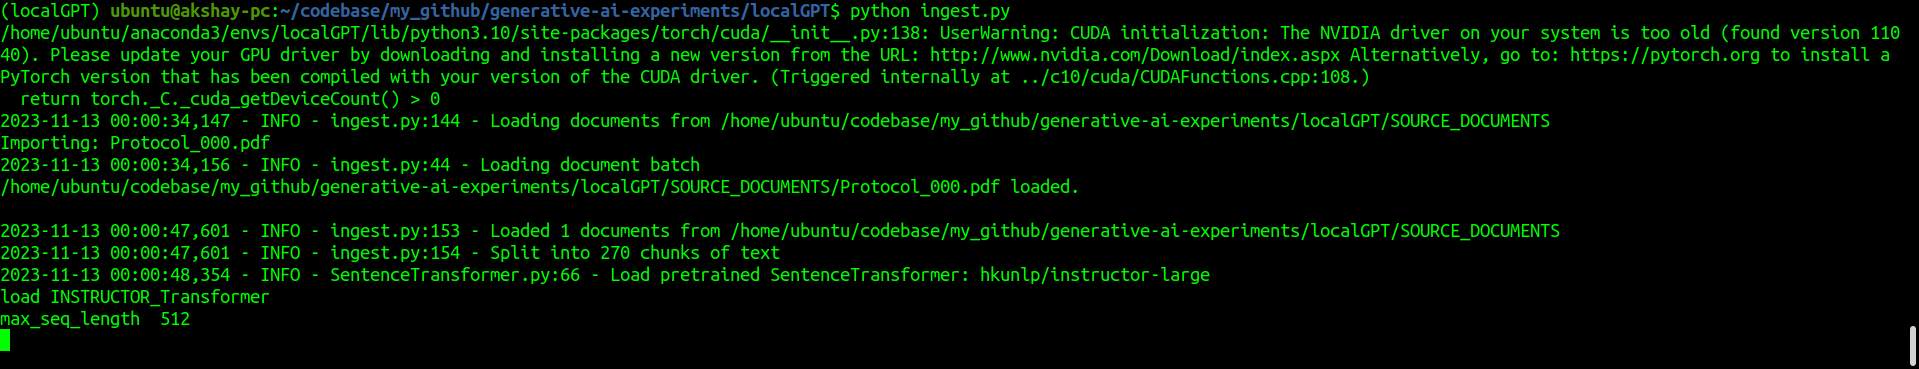

In [7]:
display.Image(f"{path}/ingest.png")

## Testing the model

The actual testing was performed on the command line terminal, so adding the screenshots here.

The testing was performed on open-access trial protocol [available on clinicaltrials.gov](https://classic.clinicaltrials.gov/ProvidedDocs/52/NCT03235752/Prot_000.pdf)

It is a 97 page protocol with a very high information density.

In [1]:
# done in py39 conda environment, not localGPT
# !pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 3.1 MB/s eta 0:00:00m eta 0:00:010:01:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
Using cached diskcache-5.6.3-py3-none-any.whl (45 kB)
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.18-cp39-cp39-manylinux_2_31_x86_64.whl size=1882343 sha256=1439826ceb73279da3ea0f139293bd97e2b79b447975cb6c4524ac6fc379fbb4
  Stored in directory: /home/ubuntu/.cache/pip/wheels/95/10/8a/af9b767b89d5d95771649e39ebd39bb9c12e726f0eea28791f
Successfully built llama-cpp-python


In [2]:
from llama_cpp import Llama

In [2]:
from llama_cpp import Llama
llm = Llama(model_path="../localGPT/models/models--TheBloke--Llama-2-7b-Chat-GGUF/snapshots/191239b3e26b2882fb562ffccdd1cf0f65402adb/llama-2-7b-chat.Q4_K_M.gguf")

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ../localGPT/models/models--TheBloke--Llama-2-7b-Chat-GGUF/snapshots/191239b3e26b2882fb562ffccdd1cf0f65402adb/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 11008,  4096,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q4_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q4_K     [  4096, 11008,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  4096,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q4_K     [  4096,  4096,     1,     1 ]
llama_m

llama_new_context_with_model: kv self size  =  256.00 MB
llama_build_graph: non-view tensors processed: 740/740
llama_new_context_with_model: compute buffer total size = 72.06 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [3]:
output = llm("Q: Can a breastfeeding women be part of this study? A: ", 
             max_tokens=500, 
             stop=["Q:", "\n"], 
             echo=True)
print(output)

{'id': 'cmpl-26f610d5-22c8-43c2-8455-be65b5859a56', 'object': 'text_completion', 'created': 1700372290, 'model': '../localGPT/models/models--TheBloke--Llama-2-7b-Chat-GGUF/snapshots/191239b3e26b2882fb562ffccdd1cf0f65402adb/llama-2-7b-chat.Q4_K_M.gguf', 'choices': [{'text': 'Q: Can a breastfeeding women be part of this study? A:  Yes, breastfeeding women are eligible to participate in this study. No special accommodations are required for breastfeeding participants. ', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 18, 'completion_tokens': 31, 'total_tokens': 49}}



llama_print_timings:        load time =     965.67 ms
llama_print_timings:      sample time =       8.76 ms /    31 runs   (    0.28 ms per token,  3539.22 tokens per second)
llama_print_timings: prompt eval time =     965.50 ms /    18 tokens (   53.64 ms per token,    18.64 tokens per second)
llama_print_timings:        eval time =    4052.14 ms /    30 runs   (  135.07 ms per token,     7.40 tokens per second)
llama_print_timings:       total time =    5088.06 ms


In [10]:
output['choices'][0]['text']

'Q: Can a breastfeeding women be part of this study? A:  Yes, breastfeeding women are eligible to participate in this study. No special accommodations are required for breastfeeding participants. '

Although this answer is not correct, **using GPU it took only a couple of seconds.**

Let's see if changing max_token makes any difference.

In [11]:
output = llm("Q: Can a breastfeeding women be part of this study? A: ", 
             max_tokens=1500, 
             stop=["Q:", "\n"], 
             echo=True)
print(output['choices'][0]['text'])

Llama.generate: prefix-match hit


Q: Can a breastfeeding women be part of this study? A:  Yes, breastfeeding women are eligible to participate in the study. everyone who meets the inclusion criteria will be considered for enrollment regardless of their feeding status. However, we ask that breastfeeding women take extra precautions to ensure the safety and health of their infant during the study.



llama_print_timings:        load time =     965.67 ms
llama_print_timings:      sample time =      18.94 ms /    65 runs   (    0.29 ms per token,  3431.17 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =    8812.67 ms /    65 runs   (  135.58 ms per token,     7.38 tokens per second)
llama_print_timings:       total time =    8960.55 ms


In [12]:
output = llm("Q: Can a breastfeeding women be part of this study? A: ", 
             max_tokens=5000, 
             stop=["Q:", "\n"], 
             echo=True)
print(output['choices'][0]['text'])

Llama.generate: prefix-match hit


Q: Can a breastfeeding women be part of this study? A:  No, breastfeeding women are not eligible to participate in this study. Breastfeeding is a crucial aspect of infant feeding and can have numerous health benefits for both the baby and mother. However, it may also impact the results of this study by altering the maternal gut microbiome. To ensure accurate and reliable findings, we need to maintain a consistent and controlled environment for all participants. As such, breastfeeding women are not eligible to participate in this study.



llama_print_timings:        load time =     965.67 ms
llama_print_timings:      sample time =      32.02 ms /   107 runs   (    0.30 ms per token,  3341.35 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =   14526.61 ms /   107 runs   (  135.76 ms per token,     7.37 tokens per second)
llama_print_timings:       total time =   14764.07 ms


#### We finally get the correct answer after increasing the context length from 500 to 500, however the rationale behind the answer seems like hallucination as the protocol does not mention "gut microbiome" .

## Testing if we can fit 70B in memory

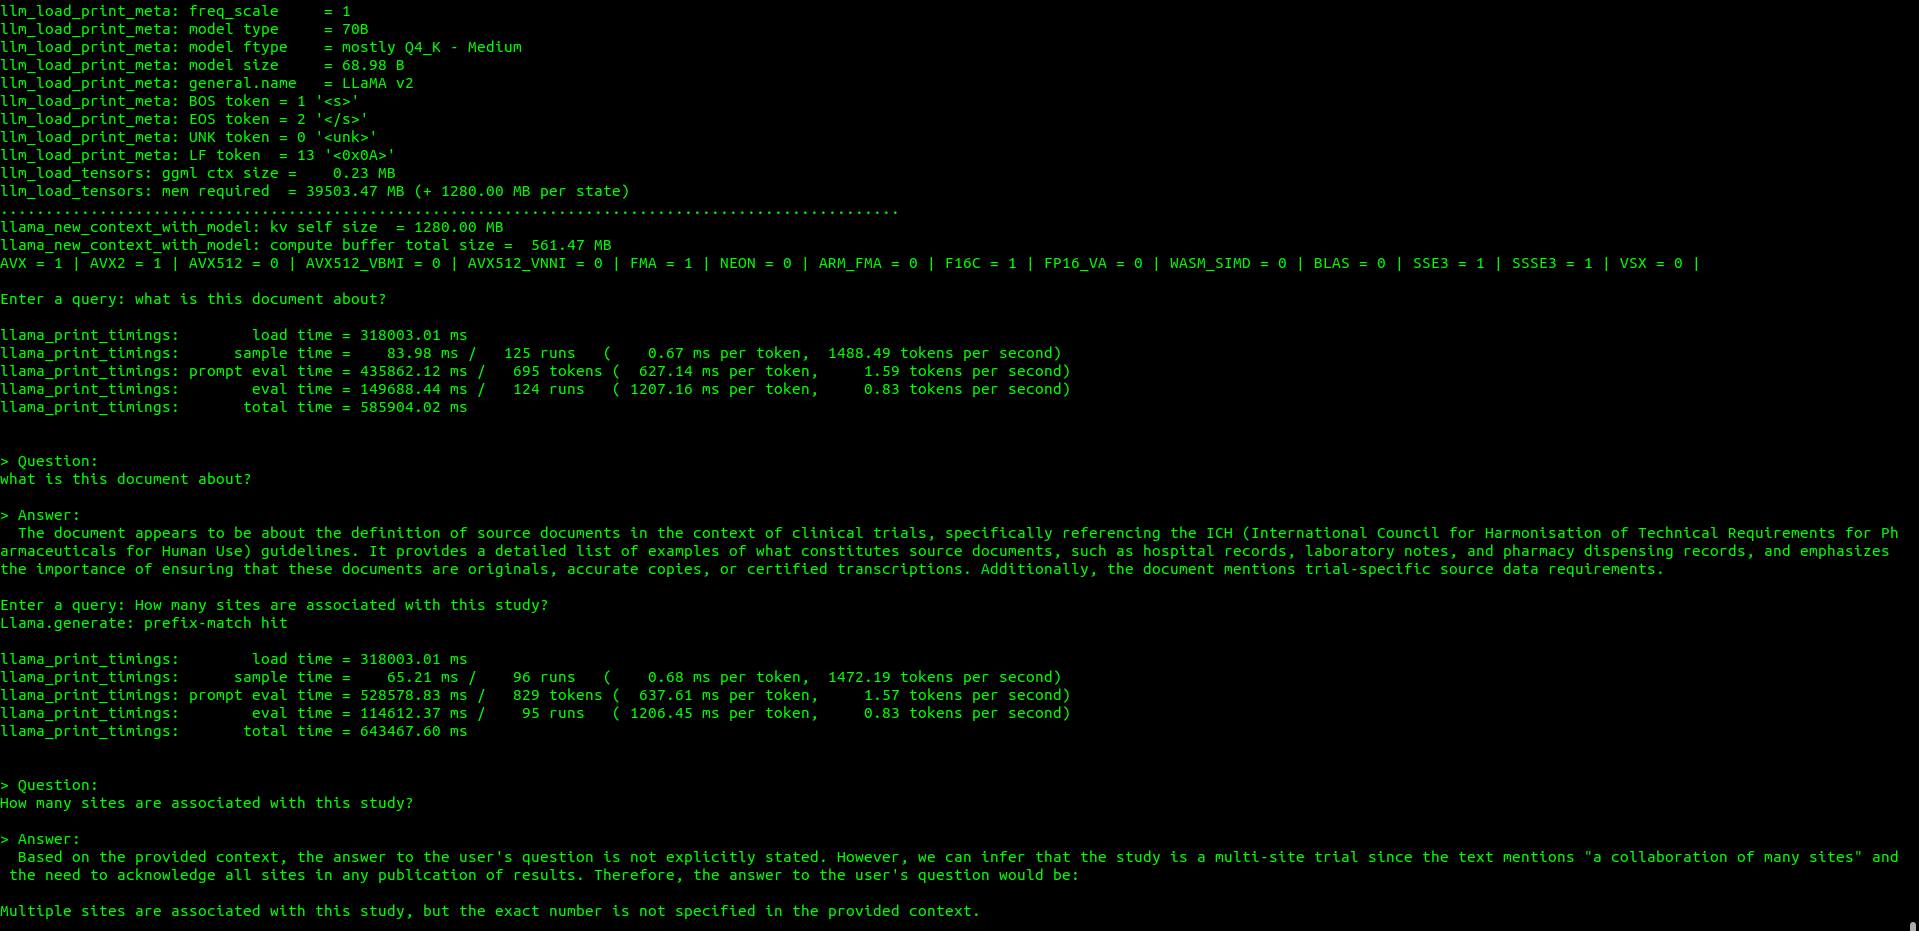

In [8]:
# older screenshot, before we setup models to use the GPU
display.Image("/home/ubuntu/Pictures/localGPT_70B/GGUF/test_run.png")

It takes a lot of time, so we will try to use the GPU based models.

In [13]:
llm = Llama(model_path="../localGPT/models/models--TheBloke--Llama-2-70B-Chat-GGUF/snapshots/6657b410331f892e2ea27eb435ef53aeefeedfd6/llama-2-70b-chat.Q4_K_M.gguf")

llama_model_loader: loaded meta data with 19 key-value pairs and 723 tensors from ../localGPT/models/models--TheBloke--Llama-2-70B-Chat-GGUF/snapshots/6657b410331f892e2ea27eb435ef53aeefeedfd6/llama-2-70b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: - tensor    0:                token_embd.weight q4_K     [  8192, 32000,     1,     1 ]
llama_model_loader: - tensor    1:           blk.0.attn_norm.weight f32      [  8192,     1,     1,     1 ]
llama_model_loader: - tensor    2:            blk.0.ffn_down.weight q6_K     [ 28672,  8192,     1,     1 ]
llama_model_loader: - tensor    3:            blk.0.ffn_gate.weight q4_K     [  8192, 28672,     1,     1 ]
llama_model_loader: - tensor    4:              blk.0.ffn_up.weight q4_K     [  8192, 28672,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_norm.weight f32      [  8192,     1,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.attn_k.weight q4_K     [  8192,  1024,     1,     1 ]
llama

....................................................................................................
llama_new_context_with_model: n_ctx      = 512
llama_new_context_with_model: freq_base  = 10000.0
llama_new_context_with_model: freq_scale = 1
llama_new_context_with_model: kv self size  =  160.00 MB
llama_build_graph: non-view tensors processed: 1844/1844
llama_new_context_with_model: compute buffer total size = 146.57 MB
AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


In [14]:
output = llm("Q: Can a breastfeeding women be part of this study? A: ", 
             max_tokens=5000, 
             stop=["Q:", "\n"], 
             echo=True)
print(output['choices'][0]['text'])

Q: Can a breastfeeding women be part of this study? A:  Yes, breastfeeding women can participate in the study. However, they will need to provide information about their breastfeeding history and any changes in their breastfeeding routine during the study period. Additionally, they will need to ensure that their breast milk is not contaminated with the study medication, which may require additional precautions such as discarding breast milk for a certain period of time after taking the medication.



llama_print_timings:        load time =    9445.84 ms
llama_print_timings:      sample time =      25.96 ms /    89 runs   (    0.29 ms per token,  3427.69 tokens per second)
llama_print_timings: prompt eval time =    9445.63 ms /    18 tokens (  524.76 ms per token,     1.91 tokens per second)
llama_print_timings:        eval time =   99456.77 ms /    88 runs   ( 1130.19 ms per token,     0.88 tokens per second)
llama_print_timings:       total time =  109104.30 ms


In [15]:
output = llm("Q: Can a breastfeeding women be part of this study? A: ", 
             max_tokens=10000, 
             stop=["Q:", "\n"], 
             echo=True)
print(output['choices'][0]['text'])

Llama.generate: prefix-match hit


Q: Can a breastfeeding women be part of this study? A:  Yes, breastfeeding women can participate in the study. However, it is important to note that the study drug may pass into breast milk and potentially harm the baby. Therefore, the investigator will need to assess the potential risks and benefits of participation for both the mother and the baby before enrolling the mother in the study. Additionally, the mother will need to provide informed consent and agree to monitor her baby for any potential side effects.



llama_print_timings:        load time =    9445.84 ms
llama_print_timings:      sample time =      26.40 ms /    91 runs   (    0.29 ms per token,  3446.84 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =  106283.08 ms /    91 runs   ( 1167.95 ms per token,     0.86 tokens per second)
llama_print_timings:       total time =  106486.72 ms


## to do

- instead of 70B model, perhaps we should try higher bit quantization of 7B or 13 B model, and more context length
- to run these experiments wit MLflow or other experiment tracking framework.